### 筆記


In [2]:
import numpy as np

def im2col(input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
    im2col_feat = []
    for n in range(N):
        for ih in range(out_h):
            for iw in range(out_w):
                im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                # each element -> (C, kh, kw)
    # input_feat -> (N*out_h*out_w, C, kh, kw)

    return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

def convolution(input_feat: np.ndarray, filter: np.ndarray, kh, kw, stride=1, padding=0, bias=None):
    '''
    input_feat: (N, C, H, W)
    filter: (out_C, in_C, kH, kw)
    bias: (out_C, 1)
    '''
    N, C, H, W = input_feat.shape
    out_h = int((H - kh + 2 * padding) // stride) + 1
    out_w = int((W - kw + 2 * padding) // stride) + 1
    out_c = filter.shape[0]
    
    if padding:
        input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

    im2col_feat = im2col(input_feat, N, kh, kw, out_h, out_w, stride)
    # im2col -> (N*out_h*out_w, C*kh*kw)

    filter = filter.reshape(out_c, -1)
    # filter -> (out_c, C*kh*kw)

    # w @ x.T
    # w -> (out_c, C*kh*kw)
    # x.T -> (C*kh*kw, N*out_h*out_w)
    if isinstance(bias, np.ndarray):
        out_feat = filter @ im2col_feat.T + bias
    else:
        out_feat = filter @ im2col_feat.T
    # out_feat -> (out_c, N*out_h*out_w)
    
    # 直接將 (out_c, N*out_h*out_w) reshape 成 (N, out_c, out_h, out_w) 會產生順序錯亂
    # 所以先將 (out_c, N*out_h*out_w) 拆成 (out_c, N, out_h, out_w) 後再 permute
    # out_feat -> (N, out_c, out_h, out_w)
    return out_feat.reshape(out_c, N, out_h, out_w).transpose(1, 0, 2, 3)
    # return out_feat.T.reshape(N, out_h, out_w, out_c).transpose(0, 3, 1, 2)
   
    
            

In [ ]:
import torch
import torch.nn.functional as F

# input feat (c, h, w) -> (3, 3, 3)
# filter (out_c, in_c, kh, kw) -> (3, 3, 2, 2)
# bias (out_c, 1)
bs = 2
feat_h = 3
feat_w = 3
kh = 2
kw = 2
in_c = 3
out_c = 3
padding = 0
stride = 1

input_feat = np.random.randint(0, 20, size=(bs, in_c, feat_h, feat_w)).astype(np.float32)
filter = np.random.randint(0, 5, size=(out_c, in_c, kh, kw)).astype(np.float32)
# bias = np.random.randint(0, 5, size=(2, 1))
bias = np.zeros((out_c, 1), dtype=np.float32)

out = convolution(input_feat, filter, kh=kh, kw=kw, stride=stride, padding=padding, bias=bias)

# 與 pytorch 的實現方法對照結果
out_t = F.conv2d(torch.tensor(input_feat), torch.tensor(filter), stride=stride, padding=padding, bias=torch.tensor(bias).squeeze(1))


print(f'input feat:\n{input_feat}')
print('======================')
print(f'filter\n:{filter}')
print('======================')
print(f'my out:\n{out}')
print(f'torch out:\n{out_t.numpy()}')
np.allclose(out, out_t)



In [180]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from my_mlp import MLP, CrossEntropyLoss
from my_nn_lib import ReLU, Softmax, LeckyReLU, Linear, BaseModule, Conv2d, Flatten
from torchvision import datasets, transforms
# import mnist



class MyModel(MLP):
    def __init__(self, layer_list):
        self.layers = layer_list

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)

        return X
    
    def backward(self, X, label):

        idx_maxlayer = len(self.layers)-1
        dLdZ = label

        for idx in range(idx_maxlayer, -1, -1):
            # 倒敘遍歷

            dLdZ = self.layers[idx].backward(delta=dLdZ)
            
    
    def update_params(self, opt_params):
        for layer in self.layers:
            layer.update_params(opt_params)
        
    def get_pred(self, X, with_onehot=False):
        pred = self.forward(X)
        if with_onehot:
            return pred
        return np.argmax(pred, axis=1)

    def train(self, X_train, Y_train, X_val, Y_val, loss_func, hyper_params: dict, show_plot=False):
        # X_train -> (n_samples, n_features)
        # Y_train -> (n_samples, n_classes) one-hot 
        
        # params = self.weight_init(self.params_set_list)

        n_samples = X_train.shape[0]

        # 將 train data 打包成 batch
        X_batch_all, Y_batch_all = self.pack_to_batch(X_train, Y_train, hyper_params['batch_size'], n_samples)
        
        train_loss_arr = []
        val_loss_arr = []
        
        val_acc_arr = []

        for i in range(hyper_params['epoch']):
            loss = 0
            print("Epoch: ", i)
            with tqdm(total=len(X_batch_all)) as pbar:
                for idx, (X_batch, Y_batch) in enumerate(zip(X_batch_all, Y_batch_all)):
                    # 單個 batch 訓練過程
                    # 1. 前向傳播
                    # 2. 反向傳播
                    # 3. 更新權重   
                    self.forward(X_batch)
                    self.backward(X_batch, Y_batch)
                    self.update_params({'lr': hyper_params['lr'], 'alpha': hyper_params['alpha']})
                    loss += loss_func.cal_loss(self.get_pred(X_batch, with_onehot=True), Y_batch)
                    pbar.update(1)
            print("Epoch: ", i)
            print('Loss:', round(loss, 2) / hyper_params['batch_size'])

            predictions = self.get_pred(X_val)
            print('Val Acc:', round(self.calculate_acc(predictions, Y_val), 2))
            
            train_loss_arr.append(loss / n_samples)

            # 取 output layer 經過 activation function 的結果為 prediction
            val_loss_arr.append(loss_func.cal_loss(self.get_pred(X_val, with_onehot=True), Y_val) / len(X_val))
            val_acc_arr.append(self.calculate_acc(predictions, Y_val))

        if show_plot:
            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)

        return train_loss_arr, val_loss_arr, val_acc_arr
    
    def train_with_dataset(self, train_dataset, loss_func, hyper_params: dict, show_plot=False):
   
        
        train_loss_arr = []
        val_loss_arr = []
        
        val_acc_arr = []
        # 定義轉換
        

        # 載入訓練和測試資料集
        


        # split train and val
        split_ratio = 0.8
        split_idx = int(len(train_dataset) * split_ratio)
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [split_idx, len(train_dataset) - split_idx])

        # 建立資料加載器
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=hyper_params['batch_size'], shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=hyper_params['batch_size'], shuffle=False)

        train_samples = train_loader.dataset.dataset.data.shape[0]
        val_samples = val_loader.dataset.dataset.data.shape[0]

        for i in range(hyper_params['epoch']):
            loss = 0
            val_loss = 0
            val_acc = 0
            print("Epoch: ", i)
            with tqdm(total=len(train_loader), desc='train:') as pbar:
                for idx, (X_batch, Y_batch) in enumerate(train_loader):
                    # 單個 batch 訓練過程
                    # 1. 前向傳播
                    # 2. 反向傳播
                    # 3. 更新權重   
                    X_batch, Y_batch = X_batch.numpy(), Y_batch.numpy()
                    Y_batch = np.eye(10)[Y_batch]
                    self.forward(X_batch)
                    self.backward(X_batch, Y_batch)
                    self.update_params({'lr': hyper_params['lr'], 'alpha': hyper_params['alpha']})
                    loss += loss_func.cal_loss(self.get_pred(X_batch, with_onehot=True), Y_batch)
                    pbar.update(1)
            print("Epoch: ", i)
            print('Loss:', round(loss, 2) / hyper_params['batch_size'])

            with tqdm(total=len(val_loader), desc='val:') as pbar:
                for idx, (X_batch, Y_batch) in enumerate(val_loader):
                    X_batch, Y_batch = X_batch.numpy(), Y_batch.numpy()
                    Y_batch = np.eye(10)[Y_batch]
                    predictions = self.get_pred(X_batch, with_onehot=True)
                    val_loss += loss_func.cal_loss(predictions, Y_batch)
                    val_acc += round(self.calculate_acc(predictions, Y_batch), 2)
                    pbar.update(1)

            train_loss_arr.append(loss / train_samples)
            val_loss_arr.append(val_loss / val_samples)

            val_acc_arr.append(val_acc / len(val_loader))
            print('Val Acc:', val_acc / len(val_loader))

        if show_plot:
            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)

        return train_loss_arr, val_loss_arr, val_acc_arr

In [4]:
import numpy as np

# making some dummy data about 3 images with 3 channels and labels
images = np.random.randint(0, 255, size=(4, 3, 10, 10)).astype(np.float32) / 255
labels = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])

model = MyModel([Conv2d(3, 4, (3, 3), 1, 0), 
                LeckyReLU(),
                Conv2d(4, 3, (3, 3), 1, 0),
                Flatten(),
                Linear(3*6*6, 3),
                Softmax()])

hyper_params = {    
    'lr': 0.01,
    'epoch': 50,
    'batch_size': 2,
    'alpha': 0.9
}
model.train(images, labels, images, labels, CrossEntropyLoss, hyper_params, show_plot=True)

(2, 4, 8, 8)
(2, 3, 6, 6)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 36 is different from 108)

In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

def wine():
    with open('data/winequality-red.csv') as f:
        # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',') for line in data]

    data = np.array(data)
    labels = []

    # 最後一個 column 為 label
    classes = np.unique(data[:, -1])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[-1] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

def iris():
    with open('data/Iris.csv') as f:
    # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',')[1:] for line in data]
    data = np.array(data)
    labels = []

    classes = np.unique(data[:, 4])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[4] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

# data, labels = iris()
data, labels = wine()
# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :-1].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 20% val)
train_size = int(len(X_data) * 0.80)


X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[train_size:], Y_data[train_size:]

hyper_params = {
    'lr': 0.01,
    'epoch': 50,
    'batch_size': 16,
    'alpha': 0.9
}


model = MyModel([Linear(11, 6), 
                 LeckyReLU(),
                 Linear(6, 6),
                 Softmax()])

# model = MyModel([Linear(4, 3), Softmax()])

params = model.train(X_train, Y_train, X_val, Y_val, CrossEntropyLoss, hyper_params, show_plot=True)
# mlp.kfold(X_data, Y_data, FOLD, SquareLoss, hyper_params)


In [6]:
images = np.random.randint(0, 255, size=(4, 3, 5, 5)).astype(np.float32)
labels = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])

model = MyModel([Conv2d(3, 1, (3, 3), 2, 0), 
                LeckyReLU(),
                Flatten(),
                Linear(2*2*1, 3),
                Softmax()])

hyper_params = {    
    'lr': 0.01,
    'epoch': 2,
    'batch_size': 2,
    'alpha': 0.9
}
model.train(images, labels, images, labels, CrossEntropyLoss, hyper_params, show_plot=True)

b:
 [[[[ 6.  0.  6.]
   [ 0.  0.  0.]
   [ 1.  0. 19.]]

  [[16.  0. 12.]
   [ 0.  0.  0.]
   [18.  0. 18.]]

  [[16.  0. 11.]
   [ 0.  0.  0.]
   [18.  0. 17.]]]]


In [20]:
import numpy as np
a = np.random.randint(0, 20, size=(2, 1, 7, 7)).astype(np.float32)
b = np.tile(a, (1, 3, 1, 1))
print('a:\n', a)
print('b:\n', b)
print(a.shape, b.shape)


a:
 [[[[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]]


 [[[18.  4.  5. 12.  8.  7. 16.]
   [15. 11. 11. 19. 18. 13.  8.]
   [ 5. 14. 10.  4.  3. 13.  1.]
   [ 1. 15. 15. 19. 13.  1.  2.]
   [18. 15. 19.  5. 17.  5. 13.]
   [16.  2.  1.  5.  6.  0. 19.]
   [15.  0. 19.  5. 18. 15. 13.]]]]
b:
 [[[[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]

  [[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]

  [[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17. 

In [13]:
import numpy as np

class Tensor(np.ndarray):
    def __new__(cls, input_array, requires_grad=False):
        # 建立 ndarray 的子類
        obj = np.asarray(input_array).view(cls)
        obj.requires_grad = requires_grad
        obj.grad = None  # 儲存梯度
        obj._grad_fn = None  # 計算梯度的函數
        return obj

    def __array_finalize__(self, obj):
        # 當新 Tensor 被創建時，繼承屬性
        if obj is None: return
        self.requires_grad = getattr(obj, 'requires_grad', False)
        self.grad = getattr(obj, 'grad', None)
        self._grad_fn = getattr(obj, '_grad_fn', None)

    def backward(self, grad_output=None):
        if not self.requires_grad:
            raise RuntimeError("This tensor does not require gradients.")
        
        if grad_output is None:
            grad_output = np.ones_like(self)
        
        if self.grad is None:
            self.grad = grad_output
        else:
            self.grad += grad_output

        if self._grad_fn:
            self._grad_fn(grad_output)

    def __repr__(self):
        return f"Tensor({super().__repr__()}, requires_grad={self.requires_grad})"


In [28]:
b = np.array([[1, 2], [3, 4]])
a = Tensor(b)
a


Tensor(Tensor([[1, 2],
        [3, 4]]), requires_grad=False)

In [7]:
import numpy as np
a = np.random.randint(0, 20, size=(3, 2, 2)).astype(np.float32)
b = np.random.randint(0, 20, size=(3, 2, 2)).astype(np.float32)
print('a:\n', a)
print('b:\n', b)
print('ab\n', a @ b)

a:
 [[[17.  2.]
  [ 6. 16.]]

 [[10. 17.]
  [10.  0.]]

 [[11. 10.]
  [16.  0.]]]
b:
 [[[ 5. 18.]
  [ 0. 18.]]

 [[ 4.  5.]
  [19. 17.]]

 [[15. 15.]
  [19.  1.]]]
ab
 [[[ 85. 342.]
  [ 30. 396.]]

 [[363. 339.]
  [ 40.  50.]]

 [[355. 175.]
  [240. 240.]]]


Epoch:  0


100%|██████████| 33/33 [04:29<00:00,  8.17s/it]


Epoch:  0
Loss: 65.890595703125
Val Acc: 0.53
Epoch:  1


100%|██████████| 33/33 [04:27<00:00,  8.11s/it]


Epoch:  1
Loss: 27.4149609375
Val Acc: 0.81
Epoch:  2


100%|██████████| 33/33 [04:26<00:00,  8.09s/it]


Epoch:  2
Loss: 17.345595703125
Val Acc: 0.84
Epoch:  3


100%|██████████| 33/33 [04:26<00:00,  8.09s/it]


Epoch:  3
Loss: 15.095107421875
Val Acc: 0.85
Epoch:  4


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  4
Loss: 14.1811328125
Val Acc: 0.86
Epoch:  5


100%|██████████| 33/33 [04:27<00:00,  8.09s/it]


Epoch:  5
Loss: 13.590830078125
Val Acc: 0.86
Epoch:  6


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  6
Loss: 13.19923828125
Val Acc: 0.87
Epoch:  7


100%|██████████| 33/33 [04:26<00:00,  8.09s/it]


Epoch:  7
Loss: 12.93
Val Acc: 0.87
Epoch:  8


100%|██████████| 33/33 [04:51<00:00,  8.83s/it]


Epoch:  8
Loss: 12.691396484375
Val Acc: 0.88
Epoch:  9


100%|██████████| 33/33 [05:05<00:00,  9.25s/it]


Epoch:  9
Loss: 12.428408203125
Val Acc: 0.88
Epoch:  10


100%|██████████| 33/33 [04:25<00:00,  8.06s/it]


Epoch:  10
Loss: 12.17658203125
Val Acc: 0.88
Epoch:  11


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  11
Loss: 11.940068359375
Val Acc: 0.89
Epoch:  12


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  12
Loss: 11.70177734375
Val Acc: 0.89
Epoch:  13


100%|██████████| 33/33 [04:26<00:00,  8.06s/it]


Epoch:  13
Loss: 11.510048828125
Val Acc: 0.89
Epoch:  14


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  14
Loss: 11.3355859375
Val Acc: 0.89
Epoch:  15


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  15
Loss: 11.169150390625
Val Acc: 0.89
Epoch:  16


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  16
Loss: 11.02400390625
Val Acc: 0.89
Epoch:  17


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  17
Loss: 10.903935546875
Val Acc: 0.9
Epoch:  18


100%|██████████| 33/33 [04:25<00:00,  8.06s/it]


Epoch:  18
Loss: 10.798173828125
Val Acc: 0.9
Epoch:  19


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  19
Loss: 10.711513671875
Val Acc: 0.9
Epoch:  20


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  20
Loss: 10.63060546875
Val Acc: 0.9
Epoch:  21


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  21
Loss: 10.545595703125
Val Acc: 0.9
Epoch:  22


100%|██████████| 33/33 [04:26<00:00,  8.06s/it]


Epoch:  22
Loss: 10.456552734375
Val Acc: 0.9
Epoch:  23


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  23
Loss: 10.380791015625
Val Acc: 0.9
Epoch:  24


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  24
Loss: 10.313740234375
Val Acc: 0.91
Epoch:  25


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  25
Loss: 10.250654296875
Val Acc: 0.91
Epoch:  26


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  26
Loss: 10.201435546875
Val Acc: 0.9
Epoch:  27


100%|██████████| 33/33 [04:25<00:00,  8.06s/it]


Epoch:  27
Loss: 10.155205078125
Val Acc: 0.9
Epoch:  28


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  28
Loss: 10.107431640625
Val Acc: 0.9
Epoch:  29


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  29
Loss: 10.07091796875
Val Acc: 0.9
Epoch:  30


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  30
Loss: 10.0309765625
Val Acc: 0.9
Epoch:  31


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  31
Loss: 9.970498046875
Val Acc: 0.91
Epoch:  32


100%|██████████| 33/33 [04:25<00:00,  8.06s/it]


Epoch:  32
Loss: 9.861572265625
Val Acc: 0.91
Epoch:  33


100%|██████████| 33/33 [04:26<00:00,  8.06s/it]


Epoch:  33
Loss: 9.7559375
Val Acc: 0.9
Epoch:  34


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  34
Loss: 9.932021484375
Val Acc: 0.9
Epoch:  35


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  35
Loss: 10.07642578125
Val Acc: 0.9
Epoch:  36


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  36
Loss: 10.158359375
Val Acc: 0.9
Epoch:  37


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  37
Loss: 10.16732421875
Val Acc: 0.9
Epoch:  38


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  38
Loss: 10.21947265625
Val Acc: 0.9
Epoch:  39


100%|██████████| 33/33 [04:26<00:00,  8.06s/it]


Epoch:  39
Loss: 10.315830078125
Val Acc: 0.89
Epoch:  40


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  40
Loss: 10.382001953125
Val Acc: 0.89
Epoch:  41


100%|██████████| 33/33 [04:27<00:00,  8.09s/it]


Epoch:  41
Loss: 10.06966796875
Val Acc: 0.9
Epoch:  42


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  42
Loss: 9.865009765625
Val Acc: 0.9
Epoch:  43


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  43
Loss: 9.780341796875
Val Acc: 0.9
Epoch:  44


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  44
Loss: 9.660341796875
Val Acc: 0.91
Epoch:  45


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  45
Loss: 9.65337890625
Val Acc: 0.91
Epoch:  46


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  46
Loss: 9.692470703125
Val Acc: 0.91
Epoch:  47


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  47
Loss: 9.5552734375
Val Acc: 0.91
Epoch:  48


100%|██████████| 33/33 [04:26<00:00,  8.07s/it]


Epoch:  48
Loss: 9.473564453125
Val Acc: 0.91
Epoch:  49


100%|██████████| 33/33 [04:26<00:00,  8.08s/it]


Epoch:  49
Loss: 9.520146484375
Val Acc: 0.91


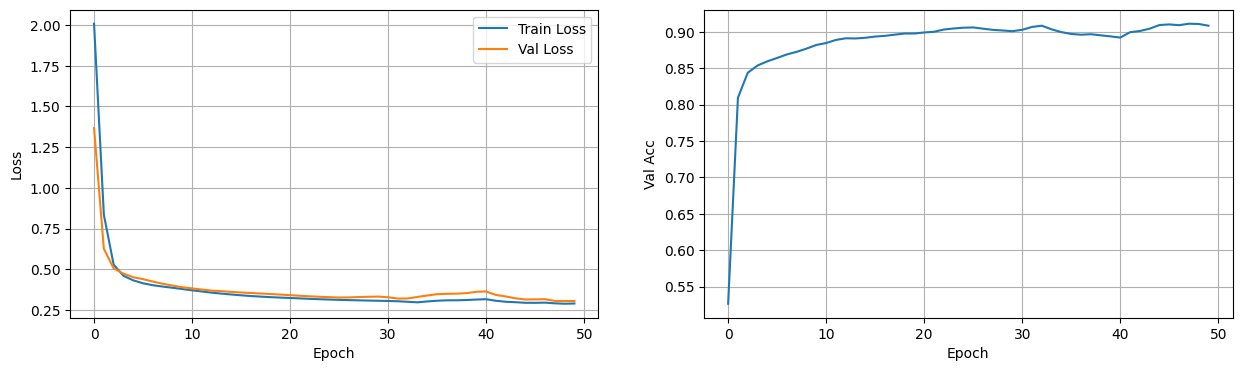

([2.0080943579759563,
  0.8355034248783111,
  0.5286276819092328,
  0.4600414227337054,
  0.432187004649933,
  0.414196669470138,
  0.4022623913741606,
  0.3940569989131759,
  0.3867852894036052,
  0.37877055691034817,
  0.3710959260478103,
  0.3638877343386751,
  0.3566256908638719,
  0.3507823341774743,
  0.3454654155504742,
  0.3403932532580472,
  0.33596957563790625,
  0.3323105066533356,
  0.32908724512302917,
  0.32644613501170683,
  0.32398036070519864,
  0.3213895201218527,
  0.3186759511460774,
  0.3163670922765783,
  0.3143234793026552,
  0.3124008089584008,
  0.31090102417938453,
  0.3094918936422436,
  0.3080360237447232,
  0.3069230916959659,
  0.30570599023878425,
  0.30386266224741204,
  0.30054312024998964,
  0.29732370994049,
  0.30269011974039195,
  0.307091048400672,
  0.3095881461183541,
  0.3098612001003747,
  0.3114504897510346,
  0.3143870973016047,
  0.3164038197842607,
  0.30688502287540925,
  0.3006478052399645,
  0.2980676503440505,
  0.2944104794704971,
  0.

In [44]:
import os
import cv2
import numpy as np

path = 'data/MNIST'

class_paths = os.listdir(path)

x_all = []
y_all = []

for cls_path in class_paths:
    img_paths = os.listdir(os.path.join(path, cls_path))
    for img_path in img_paths:
        img = cv2.imread(os.path.join(path, cls_path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))
        x_all.append(img)
        y_all.append(int(cls_path))
x_all = np.array(x_all)
y_all = np.array(y_all)

x_all = x_all.reshape(-1, 1, 28, 28) / 255

# one-hot encoding
y_one_hot = np.zeros((len(y_all), 10))
y_one_hot[np.arange(len(y_all)), y_all] = 1

# shuffle data
idx = np.arange(len(x_all))
np.random.shuffle(idx)
x_all = x_all[idx]
y_one_hot = y_one_hot[idx]



# split train and val
split_ratio = 0.8
split_idx = int(len(x_all) * split_ratio)
x_train = x_all[:split_idx]
y_train = y_one_hot[:split_idx]
x_val = x_all[split_idx:]
y_val = y_one_hot[split_idx:]

# making some dummy data about 3 images with 3 channels and labels
# images = np.random.randint(0, 255, size=(4, 3, 28, 28)).astype(np.float32) / 255
# labels = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])

model = MyModel([Conv2d(1, 9, (7, 7), 1, 0), 
                LeckyReLU(),
                Conv2d(9, 3, (5, 5), 1, 0),
                LeckyReLU(),
                Conv2d(3, 1, (1, 1), 1, 0),
                LeckyReLU(),
                Flatten(),
                Linear(1*18*18, 10),
                Softmax()])

hyper_params = {    
    'lr': 0.005,
    'epoch': 50,
    'batch_size': 1024,
    'alpha': 0.9
}
model.train(x_train, y_train, x_val, y_val, CrossEntropyLoss, hyper_params, show_plot=True)
    

array([8])

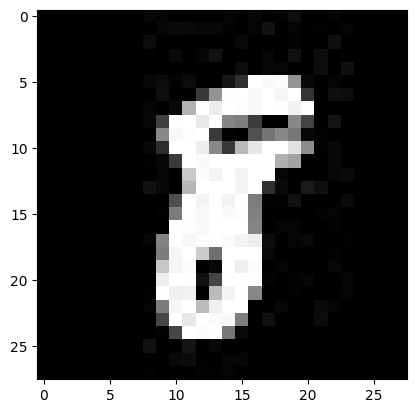

In [72]:
import matplotlib.pyplot as plt
idx = 900
plt.imshow(x_val[idx].reshape(28, 28), cmap='gray')
model.get_pred(np.expand_dims(x_val[idx], axis=0), with_onehot=False)



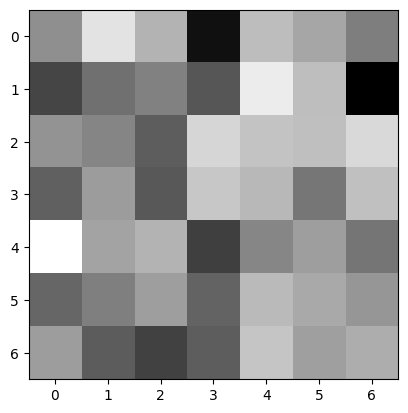

In [55]:
model.layers[0].w.shape

plt.imshow(model.layers[0].w[8, 0], cmap='gray')

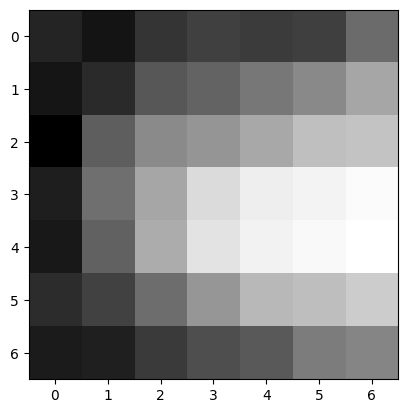

In [85]:
model.layers[0].params_delta['dW'].shape
plt.imshow(model.layers[0].params_delta['dW'][0].transpose(1, 2, 0), cmap='gray')

[5]


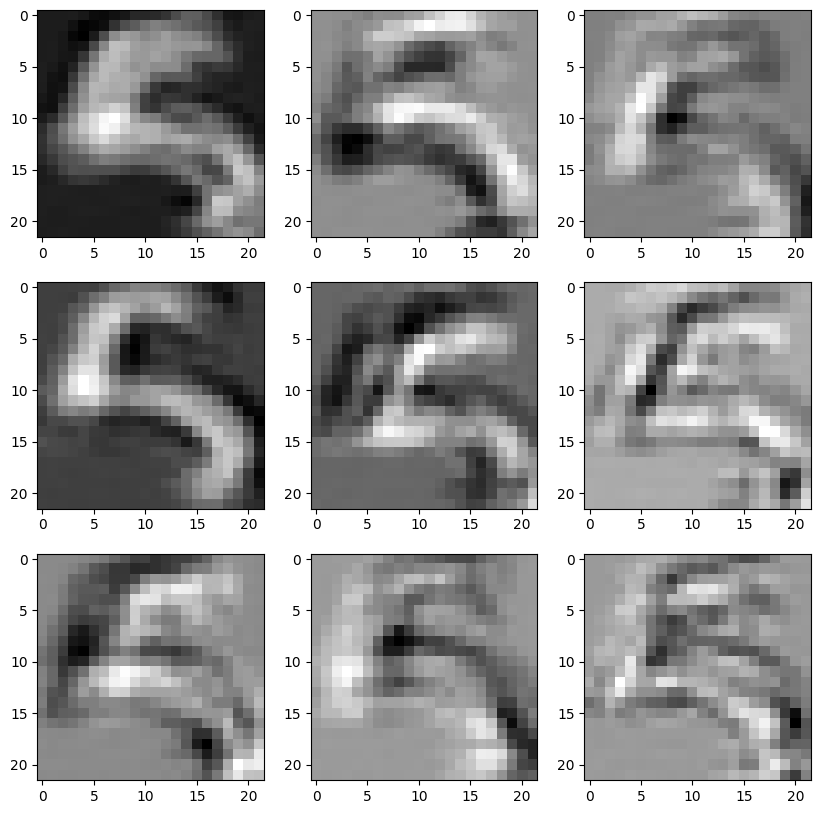

In [151]:
model.layers[2].in_feat[0].mean(axis=0, keepdims=True).shape

target_layer = 1
sample_idx = 521
print(model.get_pred(np.expand_dims(x_val[sample_idx], axis=0), with_onehot=False))

plt.figure(figsize=(10, 10))
plot_size = np.ceil(np.sqrt(len(model.layers[target_layer].in_feat[0]))).astype(int)
for idx, activation in enumerate(model.layers[target_layer].in_feat[0]):
    plt.subplot(plot_size, plot_size, idx + 1)    
    plt.imshow(np.expand_dims(activation, axis=0).transpose(1, 2, 0), cmap='gray')
    

In [183]:
import torch
from torchvision import datasets, transforms



# 載入訓練和測試資料集
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)



model = MyModel([Conv2d(3, 9, (7, 7), 1, 0), 
                LeckyReLU(),
                Conv2d(9, 3, (5, 5), 1, 0),
                LeckyReLU(),
                Flatten(),
                Linear(3*22*22, 10),
                Softmax()])

hyper_params = {    
    'lr': 0.005,
    'epoch': 10,
    'batch_size': 64,
    'alpha': 0.9
}
model.train_with_dataset(train_dataset, CrossEntropyLoss, hyper_params, show_plot=True)



Files already downloaded and verified
Epoch:  0


train:: 100%|██████████| 625/625 [11:51<00:00,  1.14s/it]


Epoch:  0
Loss: 1347.9640625


val:: 100%|██████████| 157/157 [00:15<00:00, 10.24it/s]


Val Acc: 0.0
Epoch:  1


train::   4%|▍         | 24/625 [00:27<11:30,  1.15s/it]


KeyboardInterrupt: 

In [168]:
train_loader.dataset.dataset.data.shape

(50000, 32, 32, 3)